In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd

In [2]:
# Charger le fichier CSV contenant les informations sur les infrastructures
infra_csv = pd.read_csv('data/reseau_en_arbre.csv')
infra_csv.head()

,id_batiment,nb_maisons,infra_id,infra_type,longueur
0,E000001,4,P007111,infra_intacte,12.314461
1,E000001,4,P007983,infra_intacte,40.320929
2,E000001,4,P000308,infra_intacte,39.140799
3,E000001,4,P007819,infra_intacte,17.390464
4,E000002,1,P007111,infra_intacte,12.314461


  infra_id   longueur                                           geometry
0  P007320   5.495148  LINESTRING (531440.661 259482.497, 531436.990 ...
1  P000352   3.332987  LINESTRING (531433.814 259487.594, 531436.990 ...
2  P007286   7.275098  LINESTRING (531438.662 259479.506, 531436.990 ...
3  P007115  10.593967  LINESTRING (531445.663 259480.504, 531436.990 ...
4  P007321  12.814338  LINESTRING (531447.665 259479.500, 531436.990 ...


<AxesSubplot:>

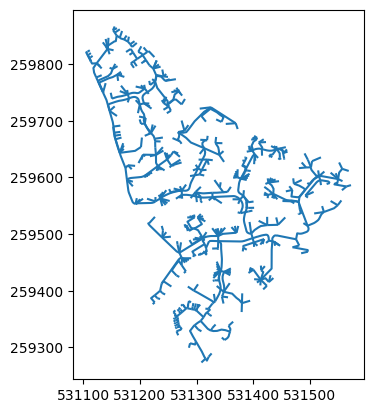

In [27]:
# Charger le fichier shape file contenant les informations sur les infrastructures
infra_gdf = gpd.read_file('data/infrastructures.shp')
print(infra_gdf.head())
infra_gdf.plot()

    id_bat  nb_maisons                       geometry
0  E000270         1.0  POINT (531436.652 259655.507)
1  E000010         1.0  POINT (531445.663 259480.504)
2  E000060         1.0  POINT (531529.658 259588.506)
3  E000200         1.0  POINT (531217.642 259637.504)
4  E000249         1.0  POINT (531369.649 259611.505)


<AxesSubplot:>

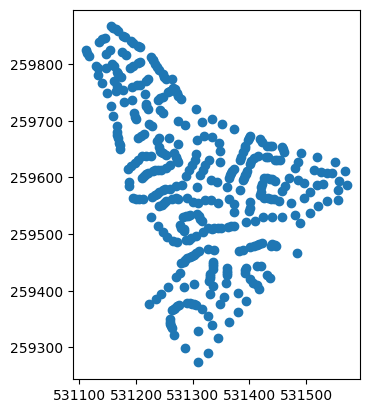

In [28]:
# Charger le fichier shape file contenant les informations sur les batiments
buildings_gdf = gpd.read_file('data/batiments.shp')
print(buildings_gdf.head())
buildings_gdf.plot()

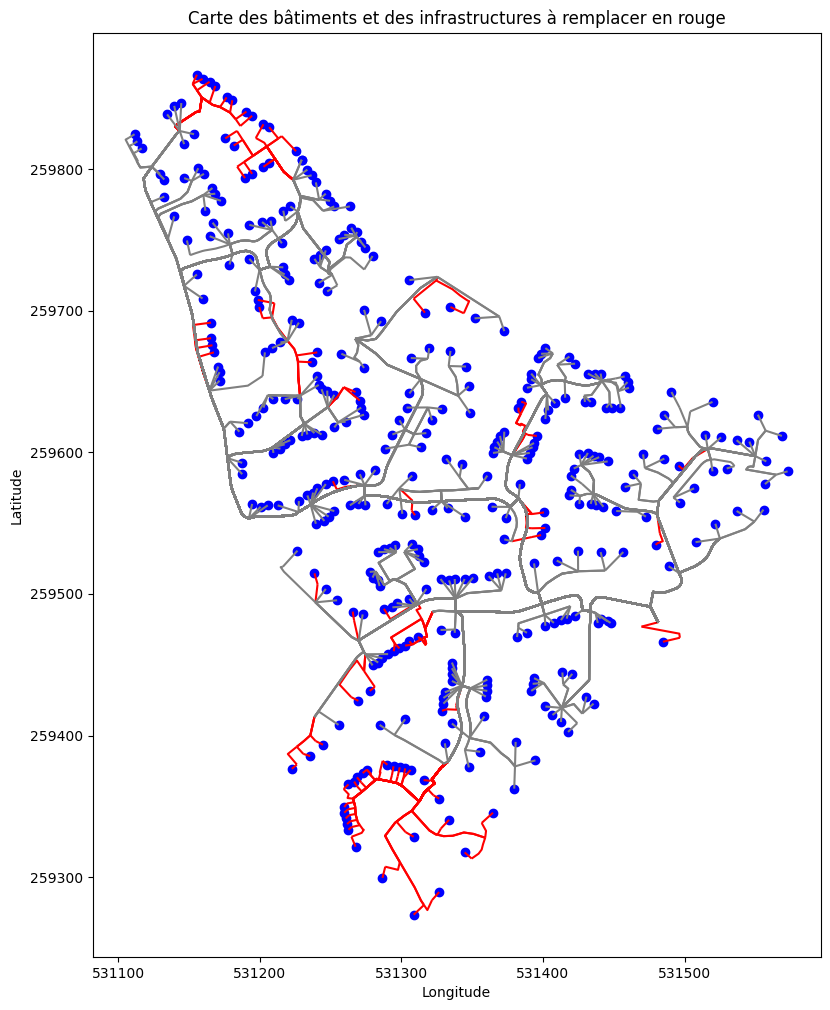

In [29]:
# Fusionner les données des infrastructures avec le GeoDataFrame correspondant
infra_gdf = infra_gdf.merge(infra_csv, left_on='infra_id', right_on='infra_id')

# Plot des bâtiments et des infrastructures
fig, ax = plt.subplots(figsize=(12, 12))

# Plot des bâtiments
buildings_gdf.plot(ax=ax, color='blue')

# Plot des infrastructures à remplacer (infra_type == 'a_remplacer')
infra_gdf[infra_gdf['infra_type'] == 'a_remplacer'].plot(ax=ax, color='red')

# Plot des autres infrastructures
infra_gdf[infra_gdf['infra_type'] != 'a_remplacer'].plot(ax=ax, color='grey')

plt.title('Carte des bâtiments et des infrastructures à remplacer en rouge')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()


In [7]:
infra_gdf.columns

Index(['infra_id', 'longueur_x', 'geometry', 'id_batiment_x', 'nb_maisons_x',
       'infra_type_x', 'longueur_y', 'id_batiment_y', 'nb_maisons_y',
       'infra_type_y', 'longueur'],
      dtype='object')

In [8]:
buildings_gdf.columns

Index(['id_bat', 'nb_maisons', 'geometry'], dtype='object')

In [10]:
# Class Infra

class Infra:
    def __init__(self, *args):
        infra_id, infra_type, nb_maisons, longueur = args
        self.infra_id = infra_id
        self.infra_type = infra_type
        self.nb_houses = nb_maisons
        self.length = round(longueur, 2)
        self.difficulty = self.get_infra_difficulty()

    def repair_infra(self):
        # Modifie le type de l'infrastructure,
        # au cas où le type était 'à réparer', alors on le met intact.

        if self.infra_type == 'a_remplacer':
            self.infra_type = 'infra_intacte'
        # return None

    def get_infra_difficulty(self):
        # La difficulté renvoit 0 si si l'infrastructure est intacte.
        # Ou bien calcule la métrique.

        if str(self.infra_type) == 'infra_intacte':
            return 0

        # Ici pour notre métrique, plus la moyenne de notre métrique est élévée,
        # plus çà sera coûteux de raccorder.
        # print(f'Difficulté infrastuctures')
        # print(f' Metrique = longueur_infra/nb_total_maison pour {self.infra_id}')
        metric = self.length / self.nb_houses
        # print(f' => nb_total_maison: {self.nb_houses}')
        # print(f' => longueur_infra: {self.length}')
        # print(f'=> Metric = {metric}')
        # print('-' * 30)

        # return Float
        return metric

    # useful like s = a_infra + b_infra
    def __add__(self, infra):
        # Additionner 2 instances

        if type(infra) != Infra:
            raise Exception("On veut la classe Infra pour pour faire l'ajout avec __add__!")

        # return Float
        return self.difficulty + infra.difficulty

    # Pour radd, on n'appelle pas l'attribut de l'instance
    # Donc pas infra.get_infra_difficulty()
    # useful like s = sum(array_object_of_infra)
    def __radd__(self, infra):
        # Va nous servir dans la classe Batiment
        # print(f'infra: {infra}')
        if type(infra) != Infra:
            raise Exception("On veut la classe Infra pour pour faire l'ajout avec __radd__!")

        # return Float
        # self.set_difficulty()
        return self.difficulty + infra

    def __lt__(self, infra):
        # Pour comparer les batiments en fonction de leur difficulté.

        if type(infra) != Infra:
            raise Exception("On veut la classe Infra pour comparer!")
        # return Bool
        return self.difficulty < infra.difficulty

    def __str__(self):
        return f'Infra Difficulty:{self.difficulty}'


In [11]:
# Class Batiment

class Batiment:
    def __init__(self, *args):
        id_batiment, list_infras = args

        self.id_building = id_batiment
        # liste de class Infra
        self.list_infras = list_infras

        self.difficulty = self.get_building_difficulty()

    def get_building_difficulty(self):
        # La metrique: somme des difficultés des infras

        # Méthode 1: (Recommended)
        # On additione directement
        # les object si on a la méthode __radd__ dans la classe Infra
        # metrique = sum(self.list_infras)

        # Methode 2:
        # on additionne en appelant les attributs
        metrique = 0
        for infra in self.list_infras:
            metrique += infra.difficulty

        # return metrique
        # return float value
        return metrique

    def __lt__(self, batiment):
        # Pour comparer les batiments en fonction de leur difficulté.

        if type(batiment) != Batiment:
            raise Exception("On veut la classe Batiment pour comparer!")
        # return Bool
        return self.difficulty < batiment.difficulty

    def __str__(self):
        return f'Batiment Difficulty:{self.difficulty}'


In [42]:
# main

network_file = './data/reseau_en_arbre.csv'
# Lire le fichier CSV avec Pandas
network_df = pd.read_csv(network_file)

########## ALGORITHME ###################

# Trier uniquement les infratructures à remplacer
network_df = network_df[network_df['infra_type'] == 'a_remplacer']
# print(f'Network shape: {network_df.shape}')
# print(f'{network_df}')

# Créer la liste des batiments
BatimentList = []

# Grouper par identifiant de l'infrature
infras_df = network_df.groupby(by='infra_id')

# Grouper par identifiant de l'infrature
batiments_df = network_df.groupby(by='id_batiment')
for index_bat, bat_df in batiments_df:
    # print(f'{index_bat}')
    # print(f'{bat_df}')
    liste_infras = []
    # print(bat_df['infra_id'])
    for infra_id in bat_df['infra_id']:
        # print(f'Grouped by {infra_id=}')
        # print(infras_df.get_group(infra_id))
        # print('-'*30)
        infra_df = infras_df.get_group(infra_id)
        # print(f'{infra_df["infra_type"].iloc[0]}')
        # print(f'{infra_df}')
        # print('_' * 30)
        infra = Infra(
            infra_id,
            infra_df['infra_type'].iloc[0],
            infra_df['nb_maisons'].sum(),
            infra_df['longueur'].sum(),
        )
        liste_infras.append(infra)
    batiment = Batiment(index_bat, liste_infras)
    BatimentList.append(batiment)

In [37]:
BatimentList[:10]

In [43]:
# Méthode du prof : (Récommandée), Placer l'ordre de priorité en fonction de la plus petite difficulté
import json 
from itertools import islice
PriorityOrder = {}
PriorityOrderDetail = {}
i = 1
while len(BatimentList) > 0:
    batiment = min(BatimentList)
    # batiment
    list_infras = batiment.list_infras
    # print(f'Batiment id: {batiment.id_building}')
    # print(f'Min infra id: {min(list_infras)}')

    bat_dic = {
        'id_batiment': batiment.id_building,
        'priority': i,
        'metric': batiment.difficulty,
        'infra_oder': ' < '.join(infra.infra_id for infra in list_infras),
        'nb_of_infras': len(list_infras)
    }
    PriorityOrder[batiment.id_building] = bat_dic
    PriorityOrderDetail[batiment.id_building] = {
        **bat_dic,
        'infras_details':{
            f'{(infra.infra_id)}':
                {'infra_id': infra.infra_id,
                 'priority': index_infra,
                 'metric': infra.difficulty,
                 'longueur': infra.length,
                 'nb_batiments_attache': int(infra.nb_houses),
                 } for index_infra, infra in enumerate(list_infras)
        }
    }
    BatimentList.remove(batiment)
    i += 1
    
# Use islice to slice the dictionary
sliced_priorities = dict(islice(PriorityOrder.items(), 15))

# Convert the object to a JSON-formatted string with indentation for readability
priority_json = json.dumps(sliced_priorities, indent=4)
print(f'Batiment Priority Order')
print(f'{priority_json}')

Batiment Priority Order
{
    "E000112": {
        "id_batiment": "E000112",
        "priority": 1,
        "metric": 20.88,
        "infra_oder": "P005664 < P007448",
        "nb_of_infras": 2
    },
    "E000098": {
        "id_batiment": "E000098",
        "priority": 2,
        "metric": 20.98,
        "infra_oder": "P005531 < P007639",
        "nb_of_infras": 2
    },
    "E000274": {
        "id_batiment": "E000274",
        "priority": 3,
        "metric": 21.16,
        "infra_oder": "P005781 < P007539",
        "nb_of_infras": 2
    },
    "E000222": {
        "id_batiment": "E000222",
        "priority": 4,
        "metric": 23.11,
        "infra_oder": "P005820 < P007627",
        "nb_of_infras": 2
    },
    "E000188": {
        "id_batiment": "E000188",
        "priority": 5,
        "metric": 23.91,
        "infra_oder": "P005915 < P002445 < P007764",
        "nb_of_infras": 3
    },
    "E000127": {
        "id_batiment": "E000127",
        "priority": 6,
        "metric

In [39]:
# Detail des priorités

# Use islice to slice the dictionary
sliced_priorities_details = dict(islice(PriorityOrderDetail.items(), 5))

priority_detail_json = json.dumps(sliced_priorities_details, indent=4)
print(f'Priority Detail')
print(f'{priority_detail_json}')

Priority Detail
{
    "E000112": {
        "id_batiment": "E000112",
        "priority": 1,
        "metric": 20.88,
        "infra_oder": "P005664 < P007448",
        "nb_of_infras": 2,
        "infras_details": {
            "P005664": {
                "infra_id": "P005664",
                "priority": 0,
                "metric": 12.91,
                "longueur": 12.91,
                "nb_batiments_attache": 1
            },
            "P007448": {
                "infra_id": "P007448",
                "priority": 1,
                "metric": 7.97,
                "longueur": 7.97,
                "nb_batiments_attache": 1
            }
        }
    },
    "E000098": {
        "id_batiment": "E000098",
        "priority": 2,
        "metric": 20.98,
        "infra_oder": "P005531 < P007639",
        "nb_of_infras": 2,
        "infras_details": {
            "P005531": {
                "infra_id": "P005531",
                "priority": 0,
                "metric": 14.85,
      